## Install Pytorch if needed

In [0]:
# http://pytorch.org/


# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

## Import modules

In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from torch.autograd.function import Function
import torch.nn.functional as F

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

batch_size = 100



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.prelu1_2 = nn.PReLU()
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.prelu2_2 = nn.PReLU()
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.prelu3_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.ip1 = nn.Linear(128 * 3 * 3, 2)
        self.ip2 = nn.Linear(2, 10)

    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x, 2)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x, 2)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 3 * 3)
        ip1 = self.preluip1(self.ip1(x))
        ip2 = self.ip2(ip1)
        return ip1, ip2


class LMCL_loss(nn.Module):
    """
        Refer to paper:
        Hao Wang, Yitong Wang, Zheng Zhou, Xing Ji, Dihong Gong, Jingchao Zhou,Zhifeng Li, and Wei Liu
        CosFace: Large Margin Cosine Loss for Deep Face Recognition. CVPR2018
        re-implement by yirong mao
        2018 07/02
        """

    def __init__(self, num_classes, feat_dim, s=7.00, m=0.2):
        super(LMCL_loss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, feat, label):
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        nfeat = torch.div(feat, norms)

        norms_c = torch.norm(self.centers, p=2, dim=-1, keepdim=True)
        ncenters = torch.div(self.centers, norms_c)
        logits = torch.matmul(nfeat, torch.transpose(ncenters, 0, 1))

        y_onehot = torch.FloatTensor(batch_size, self.num_classes)
        y_onehot.zero_()
        y_onehot = Variable(y_onehot).cuda()
        y_onehot.scatter_(1, torch.unsqueeze(label, dim=-1), self.m)
        margin_logits = self.s * (logits - y_onehot)

        return logits, margin_logits

      
      
# def visualize(feat, labels, epoch):
#     plt.ion()
#     c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
#          '#ff00ff', '#990000', '#999900', '#009900', '#009999']
#     plt.clf()
#     for i in range(10):
#         plt.plot(feat[labels == i, 0], feat[labels == i, 1], '.', c=c[i])
#     plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
#     #   plt.xlim(xmin=-5,xmax=5)
#     #   plt.ylim(ymin=-5,ymax=5)
#     plt.text(-4.8, 4.6, "epoch=%d" % epoch)
#     plt.savefig('./images/LMCL_loss_u_epoch=%d.jpg' % epoch)
#     # plt.draw()
#     # plt.pause(0.001)
#     plt.close()

def test(test_loder, criterion, model, use_cuda):
    correct = 0
    total = 0
    for i, (data, target) in enumerate(test_loder):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        data, target = Variable(data), Variable(target)

        feats, _ = model(data)
        logits, mlogits = criterion[1](feats, target)
        _, predicted = torch.max(logits.data, 1)
        total += target.size(0)
        correct += (predicted == target.data).sum()

    print('Test Accuracy of the model on the 10000 test images: %f %%' % (100 * correct / total))


def train(train_loader, model, criterion, optimizer, epoch, loss_weight, use_cuda):
    ip1_loader = []
    idx_loader = []
    for i, (data, target) in enumerate(train_loader):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        data, target = Variable(data), Variable(target)

        feats, _ = model(data)
        logits, mlogits = criterion[1](feats, target)
        # cross_entropy = criterion[0](logits, target)
        loss = criterion[0](mlogits, target)

        _, predicted = torch.max(logits.data, 1)
        accuracy = (target.data == predicted).float().mean()

        optimizer[0].zero_grad()
        optimizer[1].zero_grad()

        loss.backward()

        optimizer[0].step()
        optimizer[1].step()

        ip1_loader.append(feats)
        idx_loader.append((target))
        if (i + 1) % 50 == 0:
            print('Epoch [%d], Iter [%d/%d] Loss: %.4f Acc %.4f'
                  % (epoch, i + 1, len(train_loader), loss.data[0], accuracy))

    feat = torch.cat(ip1_loader, 0)
    labels = torch.cat(idx_loader, 0)
#     visualize(feat.data.cpu().numpy(), labels.data.cpu().numpy(), epoch)


if torch.cuda.is_available():
    use_cuda = True
else:
    use_cuda = False
# Dataset
trainset = datasets.MNIST('./data/', download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=4)

testset = datasets.MNIST('./data/', download=True, train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = DataLoader(testset, batch_size=100, shuffle=True, num_workers=4)

# Model
model = Net()

# NLLLoss
nllloss = nn.CrossEntropyLoss()
# CenterLoss
loss_weight = 0.1
lmcl_loss = LMCL_loss(num_classes=10, feat_dim=2)
if use_cuda:
    nllloss = nllloss.cuda()
    coco_loss = lmcl_loss.cuda()
    model = model.cuda()
criterion = [nllloss, lmcl_loss]
# optimzer4nn
optimizer4nn = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
sheduler_4nn = lr_scheduler.StepLR(optimizer4nn, 20, gamma=0.5)

# optimzer4center
optimzer4center = optim.SGD(lmcl_loss.parameters(), lr=0.01)
sheduler_4center = lr_scheduler.StepLR(optimizer4nn, 20, gamma=0.5)
for epoch in range(20):
    sheduler_4nn.step()
    sheduler_4center.step()
    # print optimizer4nn.param_groups[0]['lr']
    train(train_loader, model, criterion, [optimizer4nn, optimzer4center], epoch + 1, loss_weight, use_cuda)
    test(test_loader, criterion, model, use_cuda)
torch.save(model.state_dict(),"mnist_cnn-cosface.pt")        




Processing...
Done!


## Train process

In [0]:
# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# for epoch in range(1, EPOCHS + 1):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

# torch.save(model.state_dict(),"mnist_cnn-cosface.pt")


In [0]:
# # Download from COLAB
# from google.colab import files
# files.download('mnist_cnn-cosface.pt') 


## Load Model

In [3]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net()
model.eval()
model.load_state_dict(torch.load("mnist_cnn-cosface.pt", map_location='cpu'))
model.to(device)

Net(
  (conv1_1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (prelu1_1): PReLU(num_parameters=1)
  (conv1_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (prelu1_2): PReLU(num_parameters=1)
  (conv2_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (prelu2_1): PReLU(num_parameters=1)
  (conv2_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (prelu2_2): PReLU(num_parameters=1)
  (conv3_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (prelu3_1): PReLU(num_parameters=1)
  (conv3_2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (prelu3_2): PReLU(num_parameters=1)
  (preluip1): PReLU(num_parameters=1)
  (ip1): Linear(in_features=1152, out_features=2, bias=True)
  (ip2): Linear(in_features=2, out_features=10, bias=True)
)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

PREDICTION : 4


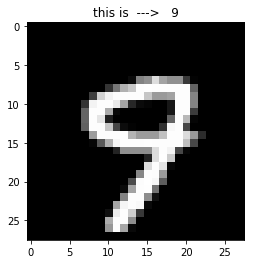

In [44]:
from pdb import set_trace as bp

class LMCL_loss2(nn.Module):
    """
        Refer to paper:
        Hao Wang, Yitong Wang, Zheng Zhou, Xing Ji, Dihong Gong, Jingchao Zhou,Zhifeng Li, and Wei Liu
        CosFace: Large Margin Cosine Loss for Deep Face Recognition. CVPR2018
        re-implement by yirong mao
        2018 07/02
        """

    def __init__(self, num_classes, feat_dim, s=7.00, m=0.2):
        super(LMCL_loss2, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, feat, label):
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        nfeat = torch.div(feat, norms)

        norms_c = torch.norm(self.centers, p=2, dim=-1, keepdim=True)
        ncenters = torch.div(self.centers, norms_c)
        logits = torch.matmul(nfeat.cpu(), torch.transpose(ncenters, 0, 1).cpu())

        y_onehot = torch.FloatTensor(batch_size, self.num_classes)
        y_onehot.zero_()
        y_onehot = Variable(y_onehot).cpu()
        y_onehot.scatter_(1, torch.unsqueeze(label, dim=-1).reshape(1,1), self.m)
        margin_logits = self.s * (logits - y_onehot)

        return logits, margin_logits



ind = 1423

image = test_loader.dataset[ind][0].numpy().reshape(28,28)
lbl = test_loader.dataset[ind][1].numpy()
plt.title('this is  --->   ' + str(lbl))
plt.imshow(image, cmap='gray')


image_tensor, label_tensor = test_loader.dataset[ind]
image_tensor = image_tensor.reshape(1,1,28,28)
image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

# features2d, prediction = model(image_tensor)
lmcl_loss = LMCL_loss2(num_classes=10, feat_dim=2)
features2d, pr = model(image_tensor)
logits, mlogits = lmcl_loss(features2d, label_tensor)
_, prediction = torch.max(logits.data, 1)
prediction = prediction.detach().numpy()[0]

print ("PREDICTION : " + str(prediction) )

-----------

In [27]:
# Visualize train_data

In [45]:
# f3d = []
f2d = []
lbls = []
for i in range(10000):
    image_tensor, label_tensor = test_loader.dataset[i]
    image_tensor = image_tensor.reshape(1,1,28,28)
    image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

#     features2d, prediction = model(image_tensor)
    features2d, pr  = model(image_tensor)
    logits, mlogits = lmcl_loss(features2d, label_tensor)
    _, prediction = torch.max(logits.data, 1)

#     f3d.append(features3d[0].cpu().detach().numpy())
    f2d.append(features2d[0].cpu().detach().numpy())
    
    prediction = prediction.detach().numpy()[0]
    lbls.append(prediction)

#     print("features3d:  " + str(features3d[0].detach().numpy()))
#     print("features2d:  " + str(features2d[0].detach().numpy()))

# feat3d = np.array(f3d)
# print("3d features shape" + str(feat3d.shape))

feat2d = np.array(f2d)
print("2d features shape" + str(feat2d.shape))

lbls = np.array(lbls)
print("labels shape" + str(lbls.shape))


2d features shape(10000, 2)
labels shape(10000,)


# Visualize 2d

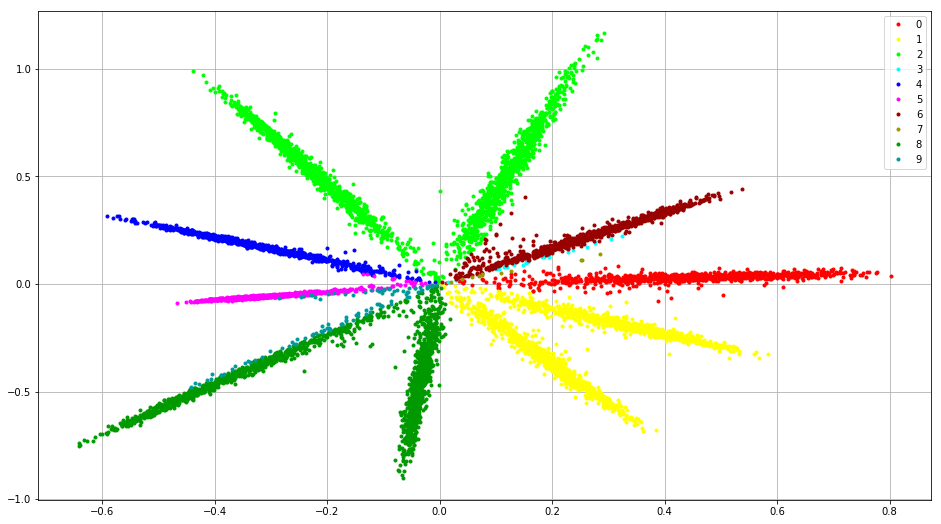

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat2d[lbls==i,0].flatten(), feat2d[lbls==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

plt.grid()
plt.show()

# Visualize 3d

In [0]:
# from mpl_toolkits import mplot3d
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig = plt.figure(figsize=(16,9))
# ax = plt.axes(projection='3d')

# for i in range(10):
#     # Data for three-dimensional scattered points
#     xdata = feat3d[lbls==i,2].flatten()
#     ydata = feat3d[lbls==i,0].flatten()
#     zdata = feat3d[lbls==i,1].flatten()
#     ax.scatter3D(xdata, ydata, zdata);
# ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

# plt.show()